# Ejercicio 5: LDA (Linear Discriminant Analysis)


---

Programen su propia implementación de LDA y utilicenlá para predecir el género de los audios procesados en el archivo dataset.csv de la carpeta Datos de la clase 6. Pueden intentar mejorar el feature engineering de los audios crudos que se encuentran en la subcarpeta Raw si así lo consideran.


## 1. Importación de librerías

Importación de librerías para manipulación de datos, balanceo de clases y operaciones numéricas, visualilzación y métricas.

In [ ]:
# Importamos las librerías necesarias
from sklearn.model_selection import train_test_split  # Para dividir datos en entrenamiento y prueba
import pandas as pd                                   # Para manipular datos en formato DataFrame
from imblearn.over_sampling import RandomOverSampler  # Para balancear clases con sobremuestreo aleatorio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 2. Implementación propia de LDA

Definición de una clase LDA con métodos `fit`, `predict` y `score`. Cálculo de medias, covarianza común y priors por clase. Implementación de la función discriminante lineal para la predicción y cálculo de la precisión del modelo.


In [ ]:
# Definimos la clase LDA (Linear Discriminant Analysis)
class LDA:
  def __init__(self):
    # Inicializamos los atributos que usaremos durante el entrenamiento y predicción
    self.clases = None         # Lista de clases únicas presentes en el conjunto de datos
    self.mu = {}               # Diccionario para almacenar las medias de cada clase
    self.sigma = None          # Matriz de covarianza común a todas las clases
    self.priors = {}           # Diccionario para almacenar las probabilidades a priori de cada clase

  def fit(self, X, y):

    # Método para entrenar el modelo con los datos X e y

    # Identificamos las clases únicas en la variable objetivo y
    self.clases = np.unique(y)

    # Inicializamos una matriz de covarianza con ceros del tamaño apropiado (n_features x n_features)
    self.sigma = np.zeros((X.shape[1], X.shape[1]))

    for k in self.clases:
      # Seleccionamos las muestras pertenecientes a la clase actual
      X_k = X[y == k]

      # Calculamos la media de las características para esta clase
      self.mu[k] = np.mean(X_k, axis=0)

      # Calculamos la probabilidad a priori como la proporción de muestras de esta clase
      self.priors[k] = len(X_k) / len(X)

      # Restamos la media de la clase a cada muestra (para calcular la covarianza)
      diff = X_k - self.mu[k]

      # Acumulamos la contribución de esta clase a la matriz de covarianza
      self.sigma += diff.T @ diff

    # Dividimos entre los grados de libertad para obtener la covarianza común
    # (len(X) - número de clases) es el ajuste para estimar correctamente la covarianza combinada
    self.sigma /= (len(X) - len(self.clases))

  def predict(self, X):
    # Método para predecir las clases de nuevos datos X

    # Intentamos invertir la matriz de covarianza; si es singular, usamos pseudoinversa
    try:
      inv_sigma = np.linalg.inv(self.sigma)
    except np.linalg.LinAlgError:
      inv_sigma = np.linalg.pinv(self.sigma)

    res = []  # Lista para almacenar las predicciones finales

    for x in X:
      probs = {}  # Diccionario para almacenar las puntuaciones discriminantes por clase
      for k in self.clases:
        # Calculamos los términos de la función discriminante lineal
        # Esta función evalúa qué tan probable es que el vector x pertenezca a cada clase,
        # considerando la media, la covarianza común y el prior de cada clase.
        term1 = 0.5 * self.mu[k] @ inv_sigma @ self.mu[k].T
        term2 = x @ inv_sigma @ self.mu[k]

        # La probabilidad (o puntuación discriminante) combina los términos y el prior
        probs[k] = self.priors[k] - term1 + term2

      # Asignamos la clase con la mayor puntuación discriminante
      res.append(max(probs, key=probs.get))

    # Convertimos las predicciones a un array de NumPy antes de devolverlas
    return np.array(res)

  def score(self, X, y):
    # Método para calcular la precisión del modelo (accuracy) en datos dados
    y_pred = self.predict(X)  # Hacemos predicciones sobre X
    # Comparamos las predicciones con las etiquetas reales y calculamos el porcentaje de aciertos
    return np.mean(y_pred == y)


## 3. Carga, análisis y preprocesamiento del dataset

Carga del dataset y eliminación de filas con valores nulos. Separación de las variables independientes y de la etiqueta. Conversión de las etiquetas a valores numéricos. Visualización de la distribución de clases antes del balanceo para justificar la necesidad de balancear. Balanceo de las clases y división de los datos en entrenamiento y prueba.

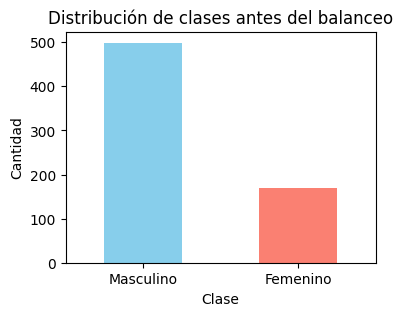

In [ ]:
# Cargargamos el dataset
df = pd.read_csv('dataset.csv')
df = df.dropna()

# Separar features y labels
X = df.drop(columns=['label'])
y = df['label'].map({"'Male'": 0, "'Female'": 1}) # Convertir a valores numericos

# Visualización de la distribución de clases antes del balanceo
plt.figure(figsize=(4,3))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de clases antes del balanceo')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0,1], labels=['Masculino', 'Femenino'], rotation=0)
plt.show()

# Resample para balancear las clases
# El balanceo es importante para evitar sesgo en la predicción, ya que si una clase tiene muchas más muestras que la otra,
# el modelo tendería a predecir siempre la clase mayoritaria.
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X, y)
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,test_size=0.2, random_state=42)


## 4. Entrenamiento y evaluación del modelo
Entrenamiento del modelo LDA y evaluación de la precisión sobre el set de prueba.

In [ ]:
# Entrenar y evaluar LDA
lda = LDA()
lda.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred_lda = lda.predict(X_test.to_numpy())
print('Precisión de LDA:', lda.score(X_test.to_numpy(), y_test.to_numpy()))


Precisión de LDA: 0.91


## 5. Visualización de resultados
Cálculo y gráfico de la matriz de confusión para analizar el desempeño del modelo.

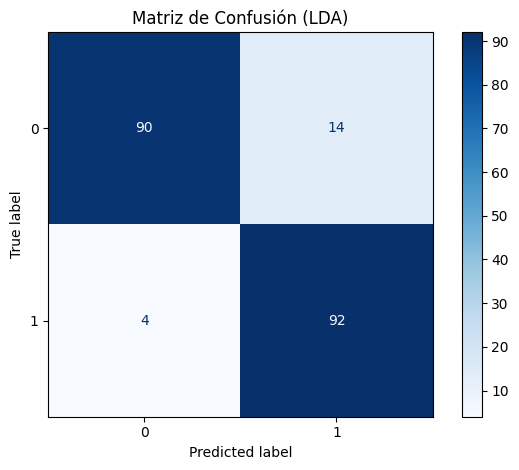

In [ ]:
# Calcular matrices de confusión
cm_lda = confusion_matrix(y_test, y_pred_lda)
disp_lda = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=lda.clases)
disp_lda.plot( cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (LDA)')

plt.tight_layout()
plt.show()


## 6. Conclusión
Al implementar y aplicar nuestro propio modelo LDA sobre el dataset de audios, obtuvimos buenos resultados en la predicción del género. La matriz de confusión muestra que el modelo diferencia bastante bien entre masculino y femenino, aunque hay algunos errores de clasificación. Esto indica que LDA es efectivo para este tipo de datos, aunque se podría mejorar ajustando los features o probando otros métodos de preprocesamiento. En general, estamos conformes con los resultados obtenidos.